# Либы

In [69]:
import pandas as pd
import numpy as np

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

In [71]:
import string

In [72]:
import pymorphy2

In [73]:
from tqdm import tqdm

In [74]:
tqdm.pandas()

# Подгрузка данных

In [75]:
data = pd.read_csv('data/filtered.csv')
data.head()

,address,name_ru,rating,rubrics,text
0,"Московская область, Электросталь, проспект Лен...",Продукты Ермолино,5,Магазин продуктов;Продукты глубокой заморозки;...,"Замечательная сеть магазинов в общем, хороший ..."
1,"Краснодар, Прикубанский внутригородской округ,...",LimeFit,1,Фитнес-клуб,"Не знаю смутят ли кого-то данные правила, но я..."
2,"Санкт-Петербург, проспект Энгельса, 111, корп. 1",Snow-Express,4,Пункт проката;Прокат велосипедов;Сапсёрфинг,Хорошие условия аренды. \nДружелюбный персонал...
3,"Тверь, Волоколамский проспект, 39",Студия Beauty Brow,5,"Салон красоты;Визажисты, стилисты;Салон бровей...",Топ мастер Ангелина топ во всех смыслах ) Немн...
4,"Иркутская область, Черемхово, Первомайская ули...",Tele2,5,Оператор сотовой связи;Интернет-провайдер,"Приятное общение, все доступно объяснили, мне ..."


In [76]:
data = data.sample(10_000)

# Preprocessing

## text preprocessing

я собираюсь добавить

фичи длины текста в словах и символах, потому что на мой взгляд, длинный текст человек готов написать только если сильно зол

фичи "добрых" и "здых" слов, потому что обычно их оставляют, если что-то понравилось/не понравилось

фичу средней длины слова, потому что, возможно, подбор более сложных и длинных слов как-то влияет на оценку

In [77]:
morph = pymorphy2.MorphAnalyzer()

pos_words = {'счастливый', 'нравится', 'люблю', 'хороший', 'любимый', 
             'лучший', 'отличный', 'радостный', 'позитивный', 'топ', 
             'спасибо', 'качетсвенный', 'положительный', 'вкусный', 
             'шикарный', 'уютный', 'прекрасный', 'неплохой', 'хорошо'}
neg_words = {'ненавижу', 'злой', 'ужасный', 'плохой', 'худший', 'скучный', 'отрицательный', 'ужасный'}

pos_lemmas = [morph.parse(word)[0].normal_form for word in pos_words]
neg_lemmas = [morph.parse(word)[0].normal_form for word in neg_words]

In [78]:
def text_preprocessing(text):
    for p in string.punctuation:
        if p in text:
            text = text.replace(p, '')
    text = text.lower()

    return text

In [79]:
def to_inf(text):
    text = text_preprocessing(text)
    list_of_words = set()
    for word in text.split(' '):
        list_of_words.add(morph.parse(word)[0].normal_form)
    return list_of_words

In [80]:
def count_words(text, words_list):
    text = to_inf(text)
    words_list = words_list

    return len(text & words_list)

## common preprocessing

In [81]:
def preprocess(data, is_train=True):
    data['rubrics'] = data['rubrics'].apply(lambda x: x.split(';')[0])
    data['region'] = data['address'].apply(lambda x: x.split(',')[0])

    data['num_bad_words'] = data['text'].progress_apply(lambda x: count_words(x, neg_words))
    data['num_good_words'] = data['text'].progress_apply(lambda x: count_words(x, pos_words))

    data['text_len_in_symbols'] = data['text'].apply(len)
    data['text_len_in_words'] = data['text'].apply(lambda x: len(x.split(' ')))

    data['mean_words_length'] = data['text_len_in_symbols'] / data['text_len_in_words']

    return data

In [82]:
data = preprocess(data)

100%|██████████| 10000/10000 [00:47<00:00, 208.36it/s]


In [83]:
data.head()

,address,name_ru,rating,rubrics,text,region,num_bad_words,num_good_words,text_len_in_symbols,text_len_in_words,mean_words_length
184599,"Ростовская область, Таганрог, улица Комарова, 4",Beermarket,5,Магазин пива,"Отличный магазин. Хорошее пиво , приветливый п...",Ростовская область,0,2,128,19,6.736842
249510,"Тюмень, улица Александра Логунова, 12/1",Пятёрочка,4,Супермаркет,"Персонал отличный, качество товара на хорошем ...",Тюмень,0,2,186,31,6.000000
408663,"Москва, Аминьевское шоссе, 6",Kvartal West,5,Торговый центр,Торговый центр новый и очень чистый. Магазинов...,Москва,0,0,166,24,6.916667
125819,"Оренбург, улица Монтажников, 23/1",Суперстройка,5,Строительный магазин,"Прекрасный магазин, у кого ремонт и стройка ре...",Оренбург,0,1,110,15,7.333333
393835,"Рязань, улица Есенина, 42",Мебель Маркет 62,5,Магазин мебели,"Заказала кухню в мебель маркете, изготовили в ...",Рязань,0,1,323,44,7.340909


In [84]:
data.to_csv('data/words_250_000.csv', index=False)

## Анализ фичей

In [86]:
data.corr(numeric_only=True)['rating']

rating                 1.000000
num_bad_words         -0.255496
num_good_words         0.233029
text_len_in_symbols   -0.294283
text_len_in_words     -0.322433
mean_words_length      0.187133
Name: rating, dtype: float64

достаточно высокие корреляции для всех признаков. странно, что длина отзыва в словах лучше влияет, чем длина в символах.

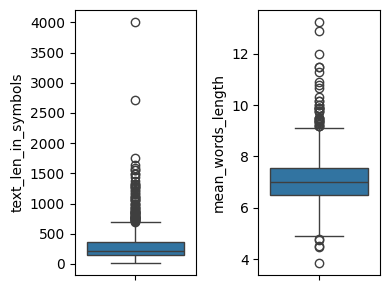

In [66]:
fig, axis = plt.subplots(1, 2, figsize=(4, 3))

sns.boxplot(data=data['text_len_in_symbols'], ax=axis[0])
sns.boxplot(data=data['mean_words_length'], ax=axis[1])

plt.tight_layout()
plt.show()

среди длин текстов есть много выбросов. большинство же отзывов нормальной длины, как и ожидалось

средняя длина слов тоже ничем не выделяется.

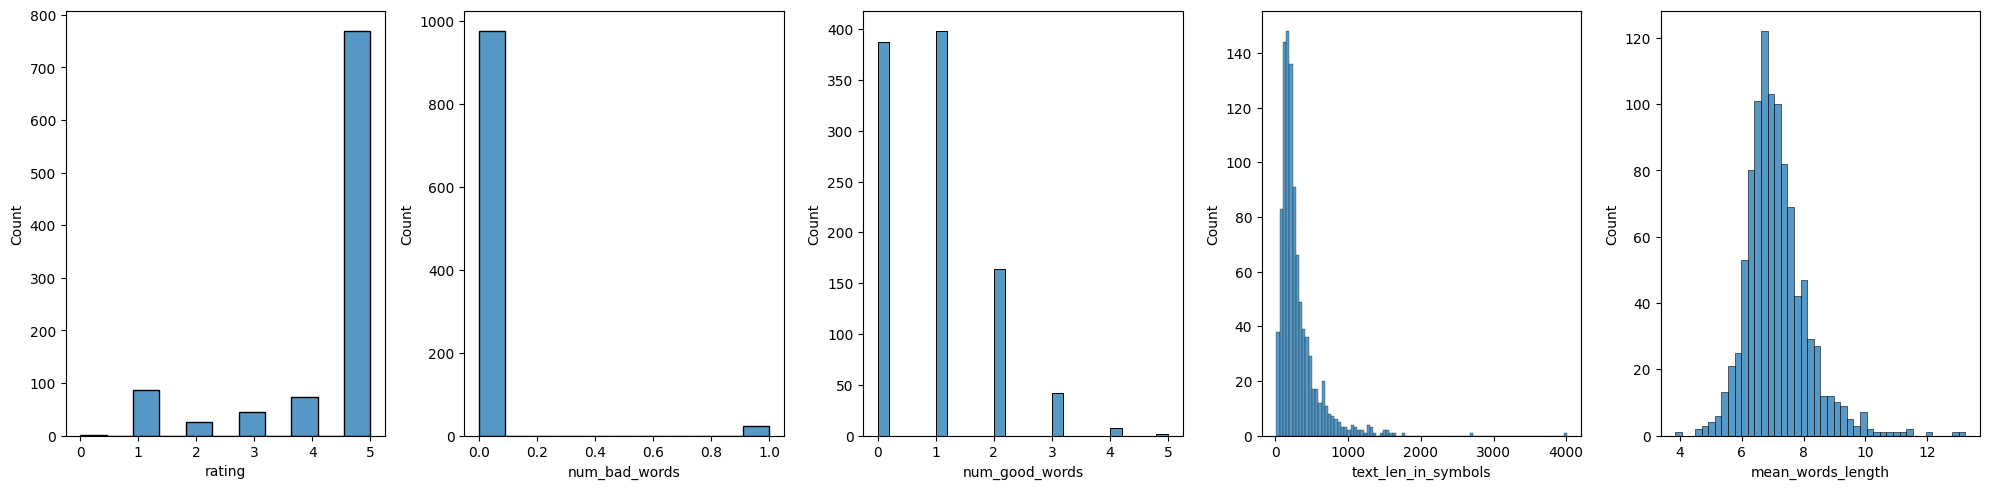

In [68]:
fig, axis = plt.subplots(1, 5, figsize=(20, 5))

sns.histplot(data['rating'], ax=axis[0])
sns.histplot(data['num_bad_words'], ax=axis[1])
sns.histplot(data['num_good_words'], ax=axis[2])
sns.histplot(data['text_len_in_symbols'], ax=axis[3])
sns.histplot(data['mean_words_length'], ax=axis[4])

plt.tight_layout()
plt.show()

можно сделать несколько выводов

1. распределение оценок стремится к распредлению Бернулли (потому что 1 и 5 ключают в себя еще удовлетворение/негодование, неописуемое цифрами)
2. плохие слова почти не оставляют, потому что большинство отзывов положительные
3. хороших слов достаточно много, что также соответсвует количеству хороших отзывов
4. распределение длины текстов хочется назвать нормальным Гауссовским, но есть сильный хвост в сторону большого количества символов
5. распределение длины слов близко к нормальному

# Промежуточные выводы

я добавил 5 фичей, каждая из которых хорошо коррелирует с оценкой полльзователя. признак количества слов в отзыве влияет незначительно сильнее, чем признак числа символов, поэтому число символов я удалю в дальнейшем, по сути они измеряют одно и то же, что лохо при построении модели.

распределение прзнаков соответсвует здравому смыслу, и, зачасутю, нормальному распределнию.